In [1]:
import warnings
import yfinance as yf 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import norm 

plt.style.use('bmh')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
ticker = 'AAPL'
data = yf.download(ticker, period='5y', interval='1d', auto_adjust=True)
print(data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed
(1260, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2017-03-20,33.140008,33.399653,33.099881,33.390213,86168000
2017-03-21,33.543639,33.706508,32.981863,33.007828,158119600
2017-03-22,33.010195,33.423265,32.988948,33.380775,103440800
2017-03-23,33.343001,33.418536,33.189577,33.262749,81385200
2017-03-24,33.399657,33.456308,33.128213,33.196663,89582400


In [3]:
returns = np.log(data[['Close']] / data[['Close']].shift(1)).dropna()
returns.rename(columns={'Close': 'Returns'}, inplace=True)
print(returns.shape)
returns.head()

(1259, 1)


,Returns
Date,
2017-03-21,-0.011518
2017-03-22,0.011235
2017-03-23,-0.003542
2017-03-24,-0.001989
2017-03-27,0.001705


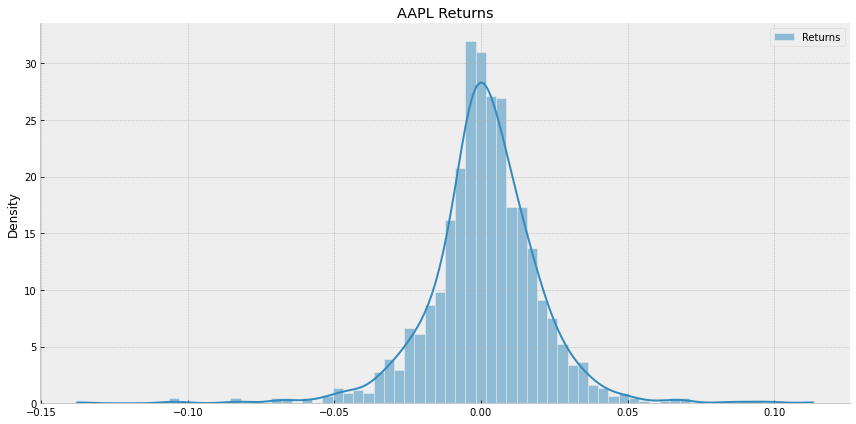

In [4]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(returns, stat='density', kde=True, ax=ax)
ax.set_title(f"{ticker} Returns")
ax.set_xlabel('')

sns.despine()
plt.tight_layout()
plt.show()

In [5]:
mu = returns.mean()
stdev = returns.std()
x = np.linspace(returns.min(), returns.max(), num=1000)
norm_dist = norm.pdf(x, loc=mu, scale=stdev)

In [6]:
color_cycle = plt.style.library['bmh']['axes.prop_cycle']
color_palette = [c['color'] for c in color_cycle]
color_palette

['#348ABD',
 '#A60628',
 '#7A68A6',
 '#467821',
 '#D55E00',
 '#CC79A7',
 '#56B4E9',
 '#009E73',
 '#F0E442',
 '#0072B2']

In [7]:
def get_gmm_pdf(data, n):
    gm = GaussianMixture(n_components=n)
    gm.fit(data)
    gm_dist = np.zeros_like(x)
    for w, m, v in zip(gm.weights_.flatten(), gm.means_.flatten(), gm.covariances_.flatten()):
        dist = norm.pdf(x, loc=m, scale=np.sqrt(v))
        gm_dist += w * dist
        
    return gm_dist

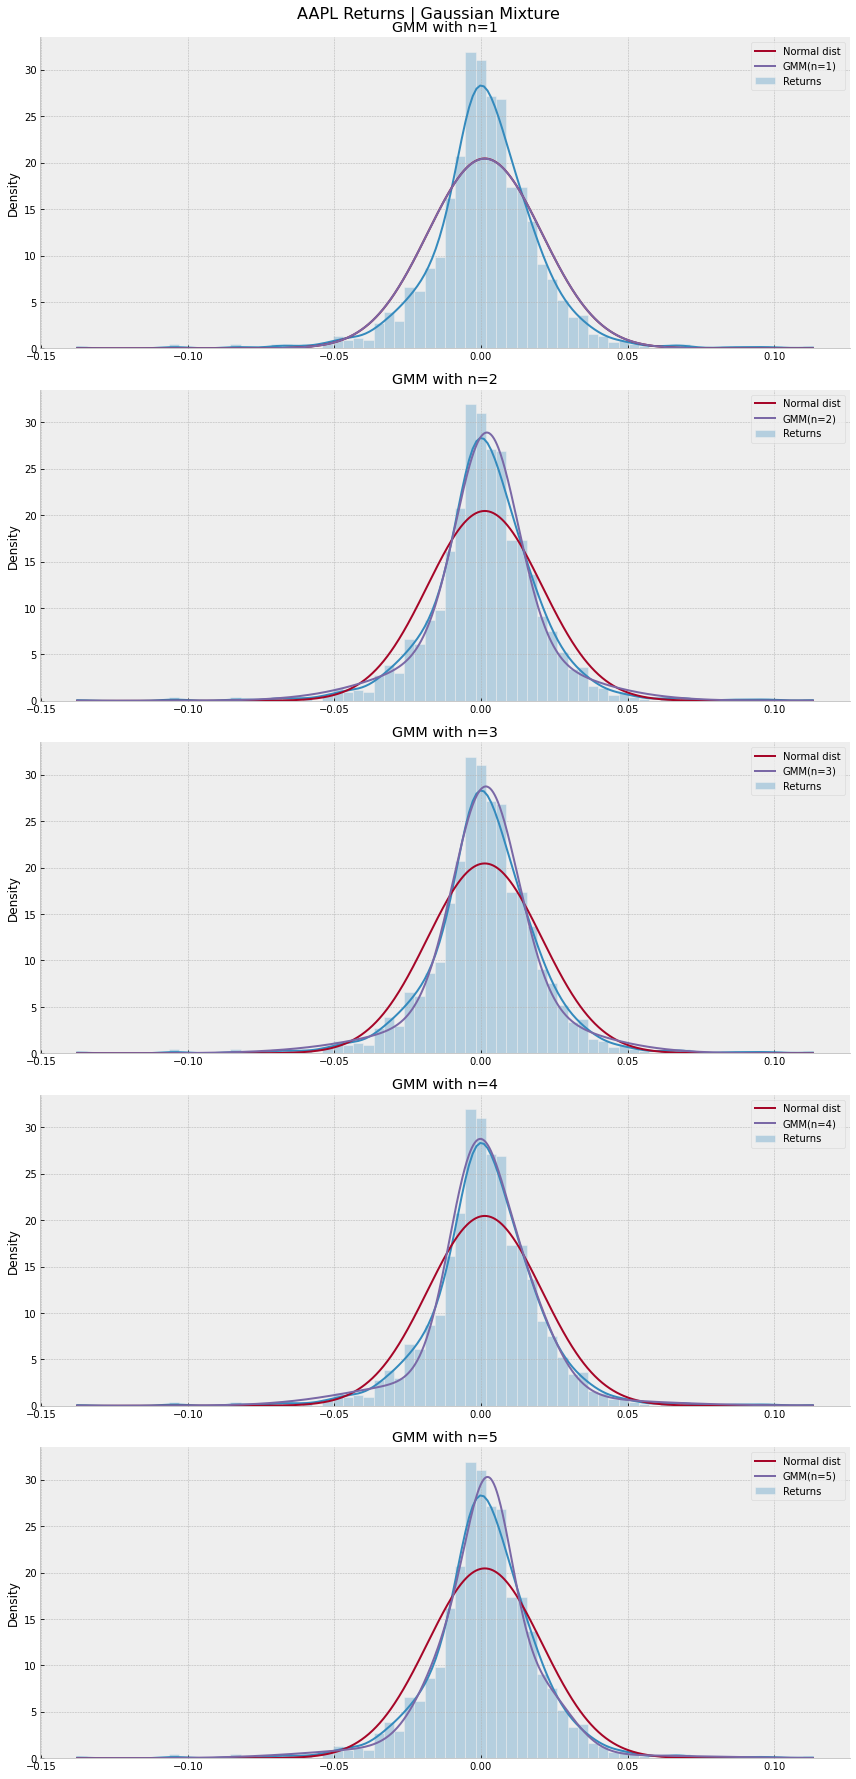

In [8]:
fig, ax = plt.subplots(5, 1, figsize=(12,25))

for i in range(5):                       
    sns.histplot(returns, stat='density', kde=True, alpha=0.3, ax=ax[i], 
                 label='Returns', color=color_palette[0])
    ax[i].plot(x, norm_dist, label=f"Normal dist", color=color_palette[1])
    ax[i].plot(x, get_gmm_pdf(returns, i+1), label=f"GMM(n={i+1})", color=color_palette[2])
    ax[i].set_xlabel('')
    ax[i].set_title(f"GMM with n={i+1}")
    ax[i].legend()

fig.suptitle(f"{ticker} Returns | Gaussian Mixture", fontsize=16, va='baseline', ha='center')
sns.despine()
plt.tight_layout()
plt.show()

In [9]:
def get_bgm_pdf(data, n):
    bgm = BayesianGaussianMixture(n_components=n)
    bgm.fit(data)
    bgm_dist = np.zeros_like(x)
    for w, m, v in zip(bgm.weights_.flatten(), bgm.means_.flatten(), bgm.covariances_.flatten()):
        dist = norm.pdf(x, loc=m, scale=np.sqrt(v))
        bgm_dist += w * dist
        
    return bgm_dist

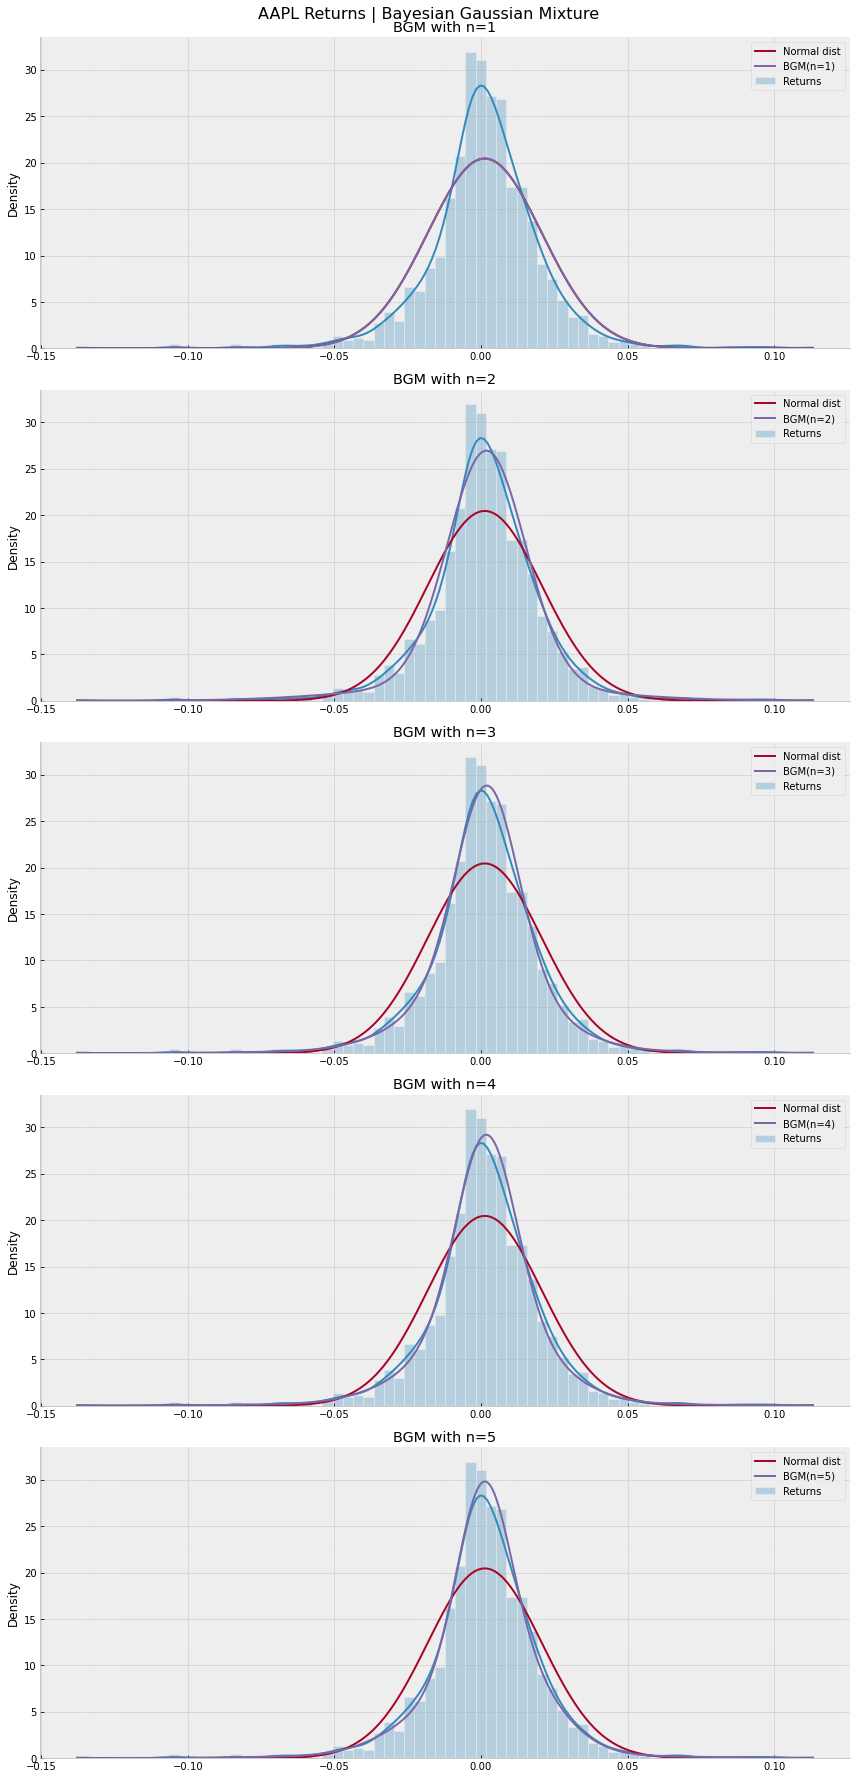

In [10]:
fig, ax = plt.subplots(5, 1, figsize=(12,25))

for i in range(5):                       
    sns.histplot(returns, stat='density', kde=True, alpha=0.3, ax=ax[i], 
                 label='Returns', color=color_palette[0])
    ax[i].plot(x, norm_dist, label=f"Normal dist", color=color_palette[1])
    ax[i].plot(x, get_bgm_pdf(returns, i+1), label=f"BGM(n={i+1})", color=color_palette[2])
    ax[i].set_xlabel('')
    ax[i].set_title(f"BGM with n={i+1}")
    ax[i].legend()

fig.suptitle(f"{ticker} Returns | Bayesian Gaussian Mixture", fontsize=16, va='baseline', ha='center')
sns.despine()
plt.tight_layout()
plt.show()